In [1]:
import os
import glob
import shutil
from pathlib import Path
import yaml
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class Config:
    def __init__(self):
        # Input paths
        self.image_dir = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images'
        self.label_dir = '/kaggle/input/fst-mask-convert'  # Output from mask_converter.py
        
        # Output paths
        self.output_dir = '/kaggle/working'
        self.dataset_dir = '/kaggle/working/dataset'
        self.data_yaml_path = '/kaggle/working/dataset.yaml'
        
        # Dataset settings
        self.val_split = 0.2
        self.seed = 42
        self.class_name = 'fragment'
        
        # Processing options
        self.visualize_samples = 0  # Number of samples to visualize (0 for none)
        self.copy_strategy = 'copy'  # 'copy' or 'symlink'
        self.mode = None  # Options: None or "Depth"

def rename_image_files(image_dir):
    """Rename image files to remove '_depth' suffix."""
    temp_dir = '/kaggle/working/temp_images'  # Writable directory
    os.makedirs(temp_dir, exist_ok=True)
    
    renamed_count = 0
    for image_file in glob.glob(os.path.join(image_dir, '*_depth.png')):
        base_name = Path(image_file).stem.replace('_depth', '')
        new_file = f"{base_name}.png"
        new_path = os.path.join(temp_dir, new_file)
        shutil.copy2(image_file, new_path)
        renamed_count += 1
    
    print(f"Renamed {renamed_count} image files in {temp_dir}")
    return temp_dir

def setup_directory_structure(config):
    """Create directory structure for YOLOv8 training."""
    dirs = {
        'dataset': config.dataset_dir,
        'train_img': os.path.join(config.dataset_dir, 'train/images'),
        'train_label': os.path.join(config.dataset_dir, 'train/labels'),
        'val_img': os.path.join(config.dataset_dir, 'val/images'),
        'val_label': os.path.join(config.dataset_dir, 'val/labels'),
    }
    
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return dirs

def create_dataset_yaml(config, dirs):
    """Create YOLO dataset YAML file."""
    yaml_content = {
        'path': dirs['dataset'],
        'train': 'train/images',
        'val': 'val/images',
        'nc': 1,
        'names': {0: config.class_name}
    }
    
    with open(config.data_yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"Created dataset YAML at {config.data_yaml_path}")
    return config.data_yaml_path

def copy_files(src_files, dst_dir, strategy='copy'):
    """Copy files to destination directory with progress bar."""
    for src in tqdm(src_files, desc=f"Copying to {os.path.basename(dst_dir)}"):
        filename = os.path.basename(src)
        dst = os.path.join(dst_dir, filename)
        
        if strategy == 'symlink' and os.name != 'nt':  # Symlinks not fully supported on Windows
            if os.path.exists(dst):
                os.remove(dst)
            os.symlink(src, dst)
        else:
            shutil.copy2(src, dst)

def copy_labels_with_depth_suffix(label_dir, output_dir):
    """Copy label files and rename them with _depth suffix."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all label files
    label_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    # Copy and rename files with _depth suffix
    for label_path in tqdm(label_files, desc="Copying and renaming depth labels"):
        filename = Path(label_path).stem
        new_filename = f"{filename}_depth.txt"
        output_path = os.path.join(output_dir, new_filename)
        
        # Copy the file with new name
        shutil.copy2(label_path, output_path)
    
    print(f"Copied {len(label_files)} label files to {output_dir} with '_depth' suffix")
    return output_dir

def setup_data(config):
    """Setup data for YOLOv8 training."""
    print("Setting up data structure for YOLOv8 training...")
    
    # Rename image files to remove '_depth' suffix if in Depth mode
    image_dir = config.image_dir
    if config.mode == "Depth":
        print("Depth mode enabled. Renaming image files to remove '_depth' suffix...")
        image_dir = rename_image_files(config.image_dir)
    
    # Create directory structure
    dirs = setup_directory_structure(config)
    
    # Get all image files
    image_paths = []
    tail = 'png' if config.mode == "Depth" else 'jpg'
    for ext in [tail]:  # Only include png since images are *.png
        image_paths.extend(glob.glob(os.path.join(image_dir, f'*.{ext}')))

    # Get label paths
    label_paths = [os.path.join(config.label_dir, f"{Path(img).stem}.txt") for img in image_paths]
    
    # Filter to only include images with corresponding labels
    valid_pairs = [(img, lbl) for img, lbl in zip(image_paths, label_paths) if os.path.exists(lbl)]
    if not valid_pairs:
        raise ValueError(f"No valid image-label pairs found! Check that {config.label_dir} contains label files.")
    
    img_paths, lbl_paths = zip(*valid_pairs)
    print(f"Found {len(img_paths)} valid image-label pairs")
    
    # Split dataset into train/val
    train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
        img_paths, lbl_paths, test_size=config.val_split, random_state=config.seed
    )
    
    print(f"Split dataset: {len(train_imgs)} training, {len(val_imgs)} validation images")
    
    # Copy files to respective directories
    copy_files(train_imgs, dirs['train_img'], config.copy_strategy)
    copy_files(train_lbls, dirs['train_label'], config.copy_strategy)
    copy_files(val_imgs, dirs['val_img'], config.copy_strategy)
    copy_files(val_lbls, dirs['val_label'], config.copy_strategy)
    
    # Create dataset YAML file
    yaml_path = create_dataset_yaml(config, dirs)
    
    # Clean up temporary image directory
    if config.mode == "Depth":
        shutil.rmtree(image_dir, ignore_errors=True)
        print(f"Cleaned up temporary directory {image_dir}")
    
    print("Data setup complete!")
    return yaml_path

def main():
    """Main function."""
    # Initialize configuration
    config = Config()
    
    # Setup data
    yaml_path = setup_data(config)
    
    print(f"Dataset prepared at: {yaml_path}")
    print("You can now run training with the YOLOv8 model.")

if __name__ == "__main__":
    main()

Setting up data structure for YOLOv8 training...
Found 768 valid image-label pairs
Split dataset: 614 training, 154 validation images


Copying to labels: 100%|██████████| 154/154 [00:00<00:00, 196.36it/s]

Created dataset YAML at /kaggle/working/dataset.yaml
Data setup complete!
Dataset prepared at: /kaggle/working/dataset.yaml
You can now run training with the YOLOv8 model.


In [2]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Training YOLOv8 segmentation model for class: fragment
Data path: /kaggle/working/dataset.yaml
Output path: /kaggle/working/
Image size: 512x512


100%|██████████| 6.74M/6.74M [00:00<00:00, 200MB/s]

Starting training for 100 epochs with image size 512...
Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fragment_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

100%|██████████| 755k/755k [00:00<00:00, 121MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 281MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2823.4±684.5 MB/s, size: 289.7 KB)


train: Scanning /kaggle/working/dataset/train/labels... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:01<00:00, 387.93it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1588.4±1302.3 MB/s, size: 331.2 KB)


val: Scanning /kaggle/working/dataset/val/labels... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<00:00, 156.64it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to /kaggle/working/runs/segment/fragment_seg/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/segment/fragment_seg
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.56G      1.718        3.2      2.105      1.339        317        512: 100%|██████████| 39/39 [00:26<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        154      10196      0.551      0.492      0.473      0.241      0.491      0.428      0.377      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.95G      1.529      2.694      1.185      1.199        632        512: 100%|██████████| 39/39 [00:21<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

                   all        154      10196      0.512      0.549      0.525      0.279      0.478      0.512       0.47      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.95G      1.445      2.558      1.056       1.17        866        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        154      10196      0.667      0.527      0.583      0.347      0.647      0.508      0.549      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.95G      1.402      2.501     0.9993      1.156        608        512: 100%|██████████| 39/39 [00:21<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

                   all        154      10196      0.691      0.562      0.616      0.373      0.691      0.545      0.596      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.95G      1.358      2.426     0.9694      1.148        436        512: 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        154      10196       0.71      0.548       0.62      0.383      0.704      0.536        0.6      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.95G      1.335      2.349     0.9336       1.13        737        512: 100%|██████████| 39/39 [00:20<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        154      10196      0.702      0.565      0.629       0.37      0.693      0.549      0.605      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.95G      1.313      2.309     0.9201      1.123        539        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        154      10196      0.728      0.619      0.682      0.421      0.723       0.61       0.67       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.95G      1.293      2.251     0.9108      1.123        394        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

                   all        154      10196      0.706       0.59      0.649      0.382      0.702      0.578       0.63      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.95G      1.297      2.255     0.8974      1.117        699        512: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]

                   all        154      10196      0.726      0.637      0.698      0.439      0.726      0.625      0.684      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.95G      1.287       2.24     0.8874      1.106        615        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

                   all        154      10196      0.729      0.624      0.695       0.44      0.731      0.607      0.674      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.95G      1.252      2.164     0.8604      1.098        728        512: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.752      0.649      0.716      0.455      0.754      0.636      0.701      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.95G      1.274      2.212      0.866      1.104        672        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        154      10196      0.766      0.635      0.713      0.455      0.767      0.627      0.703      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.95G      1.245      2.127     0.8388      1.098        425        512: 100%|██████████| 39/39 [00:19<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        154      10196      0.751      0.645       0.71      0.436      0.748      0.624      0.689      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.95G      1.265      2.184     0.8484      1.097        576        512: 100%|██████████| 39/39 [00:18<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        154      10196      0.754      0.643      0.709      0.451      0.753      0.635        0.7      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.95G      1.262      2.186     0.8344      1.091        637        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        154      10196      0.755      0.648      0.713      0.453      0.764      0.631      0.701      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.95G      1.235      2.121     0.8277      1.083        596        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        154      10196      0.783      0.662      0.739       0.47      0.783      0.648      0.723      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.95G       1.24      2.136     0.8219      1.092        391        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        154      10196      0.758      0.657      0.716      0.463       0.76      0.647      0.706      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.95G      1.239      2.133     0.8288      1.092        507        512: 100%|██████████| 39/39 [00:19<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        154      10196      0.748      0.655      0.714      0.448      0.758      0.637      0.703      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.95G      1.239      2.109     0.8258      1.086        442        512: 100%|██████████| 39/39 [00:19<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        154      10196      0.755      0.648      0.718      0.452      0.754      0.637      0.705      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.95G      1.228      2.096     0.8068      1.084        451        512: 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        154      10196      0.774      0.669      0.742      0.487      0.772      0.656      0.726      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.95G      1.218      2.076      0.803      1.083        365        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all        154      10196      0.769      0.679      0.742      0.494      0.777      0.664      0.731      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.95G      1.221      2.089     0.8103      1.073        568        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        154      10196      0.787      0.664      0.744      0.476       0.79      0.649      0.734      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.95G       1.21       2.06     0.7957      1.078        622        512: 100%|██████████| 39/39 [00:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

                   all        154      10196      0.783      0.674      0.747      0.489      0.784      0.652      0.726      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.95G      1.203      2.045     0.7901      1.073        513        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all        154      10196       0.79      0.671      0.751      0.493      0.793      0.652      0.737      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.95G      1.216      2.071     0.7876      1.074        739        512: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        154      10196      0.789      0.674      0.752      0.494      0.786       0.66      0.735      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.95G      1.182      2.008     0.7718      1.065        876        512: 100%|██████████| 39/39 [00:19<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        154      10196      0.786      0.688      0.757      0.499      0.787      0.677      0.744      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.95G      1.179      1.978      0.768      1.065        606        512: 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        154      10196      0.798      0.674      0.754      0.493      0.794      0.659      0.741      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.95G      1.186      2.006     0.7699      1.063        587        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

                   all        154      10196      0.789      0.668      0.751      0.497       0.79       0.66       0.74      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.95G       1.18      1.987     0.7611      1.063        455        512: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        154      10196      0.783      0.678      0.749      0.494      0.788      0.667       0.74      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.95G      1.183      1.994      0.757      1.056        354        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        154      10196      0.781      0.684      0.752      0.502      0.785      0.675      0.744      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.95G      1.168      1.977     0.7504      1.052        393        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.794       0.69       0.77      0.519      0.797      0.676      0.754      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.95G      1.155      1.956     0.7713      1.053        207        512: 100%|██████████| 39/39 [00:19<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        154      10196      0.809      0.694       0.77      0.504      0.807      0.683      0.759      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.95G      1.176      1.974     0.7489      1.053        471        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

                   all        154      10196        0.8      0.703      0.776      0.521        0.8      0.693      0.763      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.95G      1.155      1.933     0.7409      1.048        497        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        154      10196      0.799      0.694      0.771      0.518      0.799      0.689      0.761      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.95G      1.165      1.959      0.746      1.054        503        512: 100%|██████████| 39/39 [00:19<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        154      10196      0.798      0.689      0.764      0.523      0.804      0.677      0.757      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.95G      1.177      1.978     0.7387      1.047        620        512: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        154      10196      0.815      0.697      0.777      0.523      0.812       0.69      0.765      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.95G      1.132      1.915     0.7236       1.04        620        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        154      10196      0.813      0.694      0.777      0.524      0.812      0.681      0.762      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.95G      1.155      1.932     0.7209      1.042        769        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        154      10196      0.798        0.7      0.773      0.519      0.793      0.693      0.759      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.95G      1.154      1.937     0.7308      1.047        836        512: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

                   all        154      10196      0.823      0.694      0.783      0.524      0.822      0.684       0.77      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.95G      1.147        1.9     0.7244      1.048        371        512: 100%|██████████| 39/39 [00:19<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        154      10196       0.82       0.71      0.787      0.532      0.817      0.702      0.776      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.95G      1.124      1.891     0.7176      1.037        592        512: 100%|██████████| 39/39 [00:19<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        154      10196      0.822      0.711       0.79      0.539      0.821      0.694      0.774      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.95G      1.129       1.87     0.7074      1.034        251        512: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        154      10196      0.815      0.694      0.774      0.518      0.821      0.675      0.758      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.95G      1.129       1.88     0.7025      1.032        448        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        154      10196      0.822       0.71      0.787      0.536      0.828      0.696      0.777      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.95G      1.136      1.896      0.699      1.029        438        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        154      10196      0.828      0.708       0.79      0.544      0.825      0.703      0.782       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.95G      1.124      1.863     0.7041      1.038        643        512: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        154      10196      0.824      0.704      0.784      0.539      0.821      0.695      0.775      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.95G      1.112      1.852     0.6999      1.028        961        512: 100%|██████████| 39/39 [00:21<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        154      10196      0.831      0.709      0.787       0.54       0.83      0.702      0.777       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.95G      1.125      1.877     0.7058      1.036        756        512: 100%|██████████| 39/39 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        154      10196      0.823      0.711      0.791      0.545      0.824      0.703       0.78      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.95G      1.118       1.87     0.7002       1.03        638        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        154      10196       0.83        0.7      0.791      0.547      0.833      0.685       0.78      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.95G      1.108      1.843     0.6931      1.026        413        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        154      10196      0.822      0.713       0.79      0.539      0.829      0.701      0.778      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.95G       1.11      1.853       0.69      1.027        485        512: 100%|██████████| 39/39 [00:21<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

                   all        154      10196      0.828      0.722      0.799      0.555      0.835       0.71      0.791      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.95G      1.109      1.855     0.6886      1.025        389        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

                   all        154      10196      0.824      0.721      0.795      0.549      0.823      0.712      0.781      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.95G      1.126      1.872     0.6936      1.029        474        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        154      10196      0.831      0.716      0.797      0.548      0.836      0.703      0.785      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.95G      1.105      1.846     0.6841      1.023        533        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.828      0.711      0.797       0.55      0.825      0.697      0.784      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.95G        1.1      1.845     0.6812      1.022        852        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.843      0.718      0.799      0.552      0.842      0.708      0.785      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.95G      1.097      1.827     0.6756      1.019        485        512: 100%|██████████| 39/39 [00:19<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        154      10196      0.842      0.728      0.809      0.568       0.84      0.716      0.797      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.95G      1.089      1.816     0.6674      1.015        533        512: 100%|██████████| 39/39 [00:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

                   all        154      10196      0.836      0.725      0.802       0.55      0.834      0.707      0.787       0.49



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.95G        1.1      1.822     0.6729      1.016        462        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        154      10196      0.852      0.723      0.806      0.568      0.845      0.716      0.796      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.95G      1.101      1.818     0.6731      1.017        551        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        154      10196      0.836      0.737      0.808      0.561      0.837      0.726        0.8      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.95G      1.101      1.822     0.6685      1.018        675        512: 100%|██████████| 39/39 [00:19<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

                   all        154      10196      0.845      0.727      0.811      0.572      0.847      0.714      0.803      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.95G      1.087      1.801     0.6593      1.011        689        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

                   all        154      10196      0.846      0.732      0.815      0.572      0.845      0.723      0.805      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.95G      1.087      1.803      0.659      1.007        656        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        154      10196      0.843       0.73      0.807      0.561      0.842      0.716      0.793      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.95G      1.078      1.791     0.6577      1.008        755        512: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        154      10196      0.859      0.729      0.815      0.573      0.852      0.722      0.804      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.95G      1.073      1.794     0.6551      1.004        538        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        154      10196      0.835      0.733      0.812      0.567      0.836      0.725      0.802        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.95G       1.07       1.78     0.6511      1.007        318        512: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

                   all        154      10196      0.843      0.731      0.811      0.568      0.851      0.717        0.8      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.95G      1.075      1.779     0.6449      1.003        424        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        154      10196      0.848      0.733      0.817      0.578       0.85      0.719      0.804      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.95G      1.064       1.75     0.6435      1.001        702        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        154      10196      0.861      0.733      0.817      0.575      0.863      0.718      0.807      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.95G      1.069      1.767     0.6396     0.9996        696        512: 100%|██████████| 39/39 [00:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        154      10196      0.857      0.739       0.82      0.586      0.867      0.723      0.807      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.95G      1.059      1.754     0.6448      1.001        699        512: 100%|██████████| 39/39 [00:21<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        154      10196      0.868      0.726      0.818      0.581      0.867       0.72      0.811      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.95G      1.065      1.756     0.6366     0.9988        727        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

                   all        154      10196      0.859      0.731      0.818       0.58      0.862      0.718      0.807      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.95G      1.058      1.749      0.639      0.998        528        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        154      10196      0.842      0.743      0.815      0.577      0.848       0.73      0.807      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.95G      1.065      1.761     0.6451      1.003        337        512: 100%|██████████| 39/39 [00:21<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        154      10196      0.859       0.74      0.825      0.584      0.863      0.726      0.813      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.95G      1.048      1.734     0.6315     0.9954        742        512: 100%|██████████| 39/39 [00:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        154      10196      0.864      0.739      0.823      0.583      0.863      0.725      0.809      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.95G      1.056      1.742     0.6374     0.9975        597        512: 100%|██████████| 39/39 [00:22<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        154      10196      0.863      0.735      0.824      0.585      0.863      0.724      0.812      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.95G      1.039      1.728     0.6268     0.9906        611        512: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

                   all        154      10196      0.864      0.738      0.822      0.588      0.866      0.724      0.809      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.95G      1.055      1.749     0.6362     0.9956        418        512: 100%|██████████| 39/39 [00:20<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        154      10196      0.854      0.738      0.818       0.58      0.855      0.729       0.81      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.95G      1.064      1.765     0.6387     0.9968        671        512: 100%|██████████| 39/39 [00:22<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        154      10196      0.858      0.744      0.821      0.587       0.86      0.733      0.814      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.95G       1.05      1.735     0.6238      0.991        325        512: 100%|██████████| 39/39 [00:22<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        154      10196       0.87      0.743      0.828      0.591       0.87      0.733      0.816      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.95G      1.035      1.712     0.6177     0.9852        578        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.866      0.754      0.832      0.596      0.866       0.74       0.82      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.95G       1.03      1.703     0.6141      0.985        837        512: 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

                   all        154      10196      0.864      0.753      0.827      0.592      0.873      0.737      0.818      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.95G      1.031      1.697     0.6187     0.9881        830        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

                   all        154      10196      0.866      0.753      0.831      0.595      0.866      0.743      0.818      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.95G      1.018       1.68      0.617      0.986        409        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

                   all        154      10196      0.873      0.749       0.83      0.599      0.871       0.74      0.821      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.95G       1.03      1.706     0.6158     0.9837        545        512: 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        154      10196      0.866      0.753       0.83      0.598      0.869      0.744      0.819      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.95G      1.031      1.706     0.6116     0.9857        703        512: 100%|██████████| 39/39 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        154      10196       0.87      0.755      0.833        0.6      0.872      0.744      0.823      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.95G      1.016      1.665     0.6089      0.984        517        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        154      10196      0.876       0.75      0.833      0.604      0.874      0.739      0.823      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.95G      1.022      1.688     0.6125     0.9886        305        512: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        154      10196       0.88      0.755      0.837      0.607      0.876      0.744      0.825      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.95G      1.027      1.689     0.6147     0.9878        372        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        154      10196       0.88      0.757      0.838      0.605      0.882      0.743      0.826      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.95G      1.021      1.687     0.6066       0.98        420        512: 100%|██████████| 39/39 [00:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

                   all        154      10196      0.867       0.76      0.835      0.605       0.87       0.75      0.825      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.95G      1.023      1.704     0.6097      0.983        423        512: 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        154      10196      0.883      0.756      0.839      0.609      0.882      0.742      0.829       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.95G      1.007      1.668     0.6062     0.9839        386        512: 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        154      10196      0.879      0.757      0.839      0.613      0.884      0.741      0.827      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.95G      1.003      1.654     0.6005     0.9782        499        512: 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        154      10196      0.888      0.755      0.839      0.613      0.888      0.746      0.829      0.545


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.95G     0.9787      1.637     0.5921     0.9704        409        512: 100%|██████████| 39/39 [00:16<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        154      10196      0.877      0.751      0.833      0.601      0.879      0.741      0.822      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.95G       0.97      1.622     0.5804     0.9669        309        512: 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        154      10196      0.876      0.762      0.837      0.606      0.874      0.751      0.826      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.95G     0.9658      1.588     0.5749     0.9593        438        512: 100%|██████████| 39/39 [00:12<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        154      10196      0.879      0.757      0.839      0.611      0.884      0.748      0.829      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.95G     0.9459      1.563     0.5619     0.9538        337        512: 100%|██████████| 39/39 [00:11<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        154      10196      0.883      0.758       0.84      0.614      0.881      0.749       0.83      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.95G     0.9533      1.575     0.5618     0.9528        481        512: 100%|██████████| 39/39 [00:12<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        154      10196      0.878      0.761      0.841      0.614      0.876      0.752       0.83      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.95G     0.9505      1.569      0.563     0.9549        403        512: 100%|██████████| 39/39 [00:11<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        154      10196      0.885      0.758      0.841      0.614      0.887      0.749      0.831      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.95G     0.9375      1.551     0.5556     0.9488        312        512: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        154      10196      0.885      0.761      0.843      0.615      0.888      0.749      0.831      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.95G     0.9448      1.556     0.5597     0.9518        413        512: 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        154      10196      0.891      0.762      0.843      0.618      0.889      0.753      0.834       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.95G     0.9344      1.546     0.5521     0.9474        322        512: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        154      10196      0.883      0.767      0.844      0.619      0.886      0.755      0.834      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.95G     0.9371      1.551     0.5527     0.9474        448        512: 100%|██████████| 39/39 [00:11<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        154      10196      0.881       0.77      0.844      0.619      0.887      0.757      0.835       0.55



100 epochs completed in 0.688 hours.
Optimizer stripped from /kaggle/working/runs/segment/fragment_seg/weights/last.pt, 6.8MB
Optimizer stripped from /kaggle/working/runs/segment/fragment_seg/weights/best.pt, 6.8MB

Validating /kaggle/working/runs/segment/fragment_seg/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 1/5 [00:00<00:02,  1.34it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:02<00:04,  1.54s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


                   all        154      10196      0.881       0.77      0.845      0.619      0.886      0.757      0.835       0.55


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to /kaggle/working/runs/segment/fragment_seg


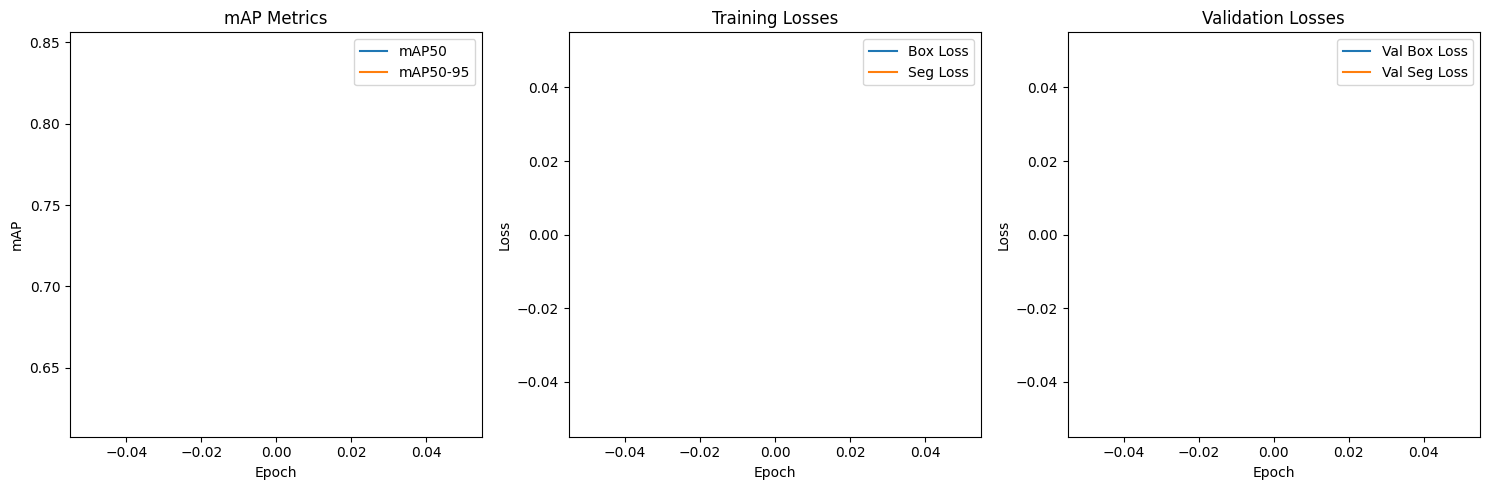

Running validation...
Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2429.6±1324.9 MB/s, size: 298.4 KB)


val: Scanning /kaggle/working/dataset/val/labels.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  10%|█         | 1/10 [00:01<00:13,  1.49s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 2/10 [00:02<00:11,  1.41s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


                   all        154      10196      0.882      0.769      0.845      0.619      0.885      0.756      0.834      0.545


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.3ms preprocess, 4.1ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/fragment_seg2
Validation Results:
mAP50: 0.8447
mAP50-95: 0.6191
Best model saved to: /kaggle/working/best.pt
Visualizing sample prediction...
Validation image directory not found at /kaggle/working/val/images
Training and evaluation completed!


In [3]:
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import shutil

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class Config:
    def __init__(self):
        # Model settings
        self.model_name = 'yolov8n-seg.pt'  # Pre-trained YOLOv8n segmentation model
        
        # Paths
        self.data_yaml = '/kaggle/working/dataset.yaml'  # Path to dataset config
        self.output_path = '/kaggle/working/'
        self.project = '/kaggle/working/runs/segment'
        self.name = 'fragment_seg'
        
        # Training parameters
        self.epochs = 100
        self.imgsz = 512  # Specified image size: 512x512
        self.batch_size = 16
        self.device = 0 if torch.cuda.is_available() else 'cpu'
        self.seed = 42
        
        # Class information
        self.classes = ['fragment']  # Single class: fragment

def visualize_sample(image_path, model=None):
    """Visualize a sample image with predictions if a model is provided"""
    plt.figure(figsize=(10, 10))
    
    # Display original image
    plt.subplot(1, 2 if model else 1, 1)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # If model is provided, show prediction
    if model:
        results = model.predict(image_path)
        result = results[0]
        
        plt.subplot(1, 2, 2)
        plt.imshow(result.plot())
        plt.title("Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def train_model(config):
    """Train YOLOv8 segmentation model."""
    print(f"Training YOLOv8 segmentation model for class: {config.classes[0]}")
    print(f"Data path: {config.data_yaml}")
    print(f"Output path: {config.output_path}")
    print(f"Image size: {config.imgsz}x{config.imgsz}")
    
    # Load model
    model = YOLO(config.model_name)
    
    # Train model
    print(f"Starting training for {config.epochs} epochs with image size {config.imgsz}...")
    results = model.train(
        data=config.data_yaml,
        epochs=config.epochs,
        imgsz=config.imgsz,
        batch=config.batch_size,
        device=config.device,
        project=config.project,
        name=config.name,
        seed=config.seed
    )
    
    # Plot training results
    metrics = results.results_dict
    plt.figure(figsize=(15, 5))
    
    # Plot mAP
    plt.subplot(1, 3, 1)
    plt.plot(metrics.get('metrics/mAP50(B)', []), label='mAP50')
    plt.plot(metrics.get('metrics/mAP50-95(B)', []), label='mAP50-95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP Metrics')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(metrics.get('train/box_loss', []), label='Box Loss')
    plt.plot(metrics.get('train/seg_loss', []), label='Seg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(1, 3, 3)
    plt.plot(metrics.get('val/box_loss', []), label='Val Box Loss')
    plt.plot(metrics.get('val/seg_loss', []), label='Val Seg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Losses')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.output_path, "training_metrics.png"))
    plt.show()
    
    return model, results

def evaluate_model(model, config):
    """Evaluate the trained model on validation data."""
    print("Running validation...")
    val_results = model.val()
    print("Validation Results:")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Save model
    best_model_path = os.path.join(config.project, config.name, "weights/best.pt")
    save_path = os.path.join(config.output_path, "best.pt")
    shutil.copy(best_model_path, save_path)
    print(f"Best model saved to: {save_path}")
    
    # Visualize a sample prediction
    print("Visualizing sample prediction...")
    dataset_dir = os.path.dirname(config.data_yaml)
    val_img_dir = os.path.join(os.path.dirname(config.data_yaml), 'val/images')
    
    if os.path.exists(val_img_dir):
        sample_images = os.listdir(val_img_dir)
        if sample_images:
            sample_image = os.path.join(val_img_dir, sample_images[0])
            visualize_sample(sample_image, model)
        else:
            print("No validation images found for visualization")
    else:
        print(f"Validation image directory not found at {val_img_dir}")
    
    return val_results

def main():
    """Main function."""
    # Initialize configuration
    config = Config()
    
    # Train model
    model, results = train_model(config)
    
    # Evaluate model
    evaluate_model(model, config)
    
    print("Training and evaluation completed!")

if __name__ == '__main__':
    main()

Model loaded successfully from /kaggle/working/best.pt

Evaluating inference time with 50 separate runs...
Performing a warm-up inference run...
Warm-up complete.
Completed run 10/50 on 120.jpg in 0.2727s
Completed run 20/50 on 437.jpg in 0.2742s
Completed run 30/50 on 530.jpg in 0.4223s
Completed run 40/50 on 205.jpg in 0.3170s
Completed run 50/50 on 794.jpg in 0.4479s

--- Separate Inference Runs Timing Summary ---
Number of runs successfully timed: 50 / 50
Total time for all 50 separate runs: 20.8176 seconds
Average inference time per run: 0.4164 seconds
Median inference time per run: 0.3840 seconds
Minimum inference time per run: 0.1352 seconds
Maximum inference time per run: 1.1480 seconds
Standard deviation of inference time: 0.1989 seconds

--- Running and Visualizing One Example ---
Running inference for visualization on: /kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images/530.jpg

image 1/1 /kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/

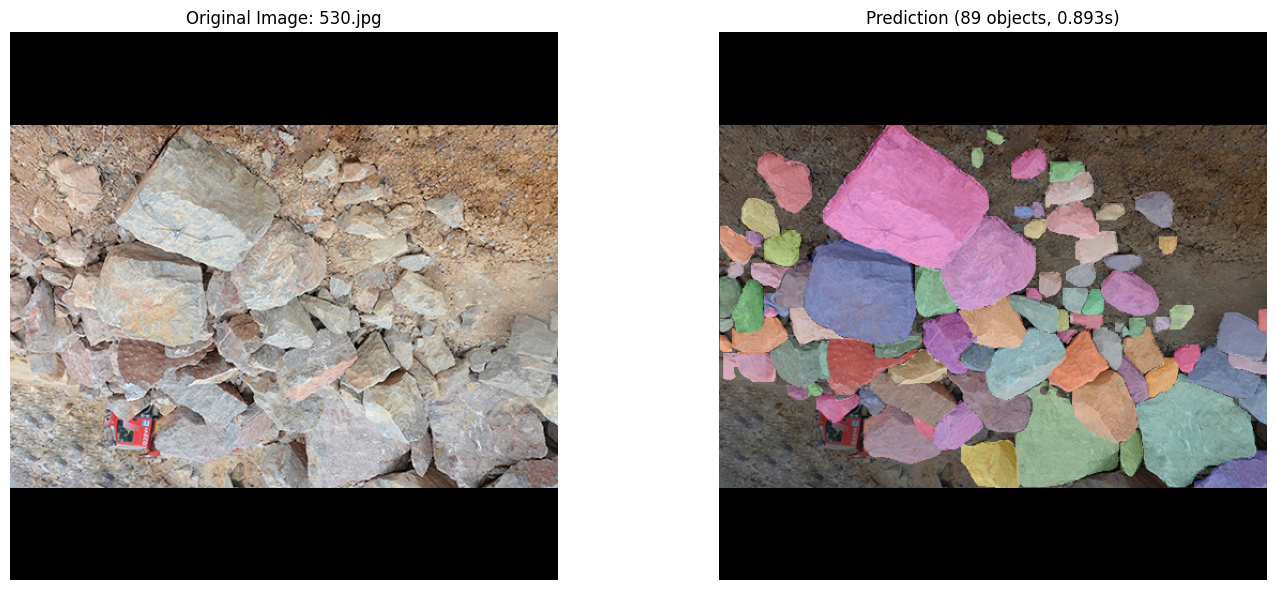


Evaluation script finished.


In [4]:
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import cv2
import time
from pathlib import Path

# Set random seed for reproducibility
torch.manual_seed(40)
np.random.seed(40)
random.seed(40)

class Config:
    def __init__(self):
        # Model settings
        self.model_path = '/kaggle/working/best.pt'  # Path to trained model
        
        # Inference settings
        self.conf_threshold = 0.25  # Confidence threshold
        self.iou_threshold = 0.7   # IoU threshold for NMS
        self.device = 'cpu'         # Force CPU usage
        
        # --- Settings for Separate Inference Runs Timing ---
        self.image_dir_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images' 
        self.num_separate_runs_for_timing = 50 # Number of separate inference runs on different images

        # --- Output Settings for the Single Visualized Example ---
        self.output_path_base = '/kaggle/working/inference_eval_outputs' 
        
        # Inference/Visualization settings for YOLO predict calls
        self.imgsz = 512            # Same size used during training
        # Updated based on deprecation warnings:
        self.show_labels = False    # Set to True to show labels (previously hide_labels=True)
        self.show_conf = False      # Set to True to show confidences (previously hide_conf=True)
        self.show_boxes = False     # Set to True to show bounding boxes (previously boxes=False for predict)
        
        # Class information
        self.classes = ['fragment']  # Single class: fragment

def load_model(config):
    """Load the trained YOLOv8 model"""
    try:
        model = YOLO(config.model_path)
        print(f"Model loaded successfully from {config.model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def get_random_image_paths(image_dir_str, num_images, extensions=('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
    """Gets a list of random image paths from a directory."""
    image_dir = Path(image_dir_str)
    if not image_dir.is_dir():
        print(f"Error: Provided image path '{image_dir_str}' is not a directory.")
        return []

    all_image_files = []
    for ext in extensions:
        all_image_files.extend(list(image_dir.rglob(f'*{ext}')))
    
    all_image_files = [str(p) for p in all_image_files] 

    if not all_image_files:
        print(f"No images found in '{image_dir_str}' with extensions {extensions}")
        return []

    if len(all_image_files) < num_images:
        print(f"Warning: Requested {num_images} images, but only found {len(all_image_files)}. Using all {len(all_image_files)} found images.")
        if not all_image_files: return []
        return random.choices(all_image_files, k=num_images)
    else:
        return random.sample(all_image_files, num_images)


def evaluate_separate_inference_runs(model, image_paths, config):
    """Runs a separate model.predict() call for each image and collects timing."""
    if not model:
        print("No model loaded. Cannot run inference for timing evaluation.")
        return None

    inference_times = []
    
    print(f"\nEvaluating inference time with {len(image_paths)} separate runs...")
    
    if image_paths:
        print("Performing a warm-up inference run...")
        valid_warmup_path = next((p for p in image_paths if os.path.exists(p)), None)
        if valid_warmup_path:
            try:
                _ = model.predict(
                    source=valid_warmup_path,
                    conf=config.conf_threshold, iou=config.iou_threshold, imgsz=config.imgsz,
                    device=config.device, save=False, visualize=False, verbose=False,
                    retina_masks=True, 
                    show_boxes=config.show_boxes # Updated
                )
                print("Warm-up complete.")
            except Exception as e:
                print(f"Warm-up run failed for {valid_warmup_path}: {e}")
        else:
            print("Warm-up skipped: No valid image path found in the provided list for warm-up.")


    for i, image_path in enumerate(image_paths):
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}, skipping run {i+1}.")
            continue

        try:
            start_time = time.time()
            _ = model.predict(
                source=image_path, 
                conf=config.conf_threshold,
                iou=config.iou_threshold,
                imgsz=config.imgsz,
                device=config.device,
                save=False, save_txt=False, project=None, name=None,
                visualize=False, 
                show_labels=config.show_labels, # Updated
                show_conf=config.show_conf,     # Updated
                show_boxes=config.show_boxes,   # Updated
                retina_masks=True, verbose=False 
            )
            end_time = time.time()
            current_inference_time = end_time - start_time
            inference_times.append(current_inference_time)
            if (i + 1) % 10 == 0 or i == len(image_paths) - 1:
                 print(f"Completed run {i+1}/{len(image_paths)} on {Path(image_path).name} in {current_inference_time:.4f}s")
        except Exception as e:
            print(f"Error during inference for {image_path} (run {i+1}): {e}")
            
    if not inference_times:
        print("No images were successfully processed for timing.")
        return []
        
    return inference_times

def visualize_single_result(result, img_path, inference_time, output_visualization_path, config): # Added config
    """Visualize single image prediction with side-by-side comparison.
       Saves the custom plot to output_visualization_path.
    """
    if result is None:
        print("No result to visualize")
        return
    
    os.makedirs(Path(output_visualization_path).parent, exist_ok=True)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    try:
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Original Image: {Path(img_path).name}")
    except Exception as e:
        plt.title(f"Could not load original: {Path(img_path).name}\n{e}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    if hasattr(result, 'masks') and result.masks is not None and len(result.masks.data) > 0:
        orig_img = cv2.imread(img_path)
        if orig_img is not None:
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            masks_data = result.masks.data.cpu().numpy()
            mask_img = np.zeros_like(orig_img)
            
            for j, mask in enumerate(masks_data):
                color = np.array([random.randint(50, 255), random.randint(50, 200), random.randint(50, 200)])
                mask_h, mask_w = mask.shape
                img_h, img_w = orig_img.shape[:2]
                bin_mask = mask.astype('uint8')
                if mask_h != img_h or mask_w != img_w:
                    bin_mask = cv2.resize(bin_mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
                mask_img[bin_mask > 0] = color
            
            alpha = 0.5
            blended = cv2.addWeighted(orig_img, 1 - alpha, mask_img, alpha, 0)
            plt.imshow(blended)
            plt.title(f"Prediction ({len(masks_data)} objects, {inference_time:.3f}s)")
        else:
            # Use result.plot for fallback if CV2 fails
            plt.imshow(result.plot(
                show_boxes=config.show_boxes, 
                show_labels=config.show_labels, 
                show_conf=config.show_conf
            ))
            plt.title(f"Prediction (CV2 Load Fail, {inference_time:.3f}s)")
    else:
        # Use result.plot if no masks or for default plotting
        plt.imshow(result.plot(
            show_boxes=config.show_boxes, 
            show_labels=config.show_labels, 
            show_conf=config.show_conf
        ))
        plt.title(f"Prediction (No masks or default plot, {inference_time:.3f}s)")
    
    plt.axis('off')
    plt.tight_layout()
    
    plt.savefig(output_visualization_path)
    print(f"Custom visualization saved to {output_visualization_path}")
    plt.show()
    plt.close()

def main():
    """Main function"""
    config = Config() 
    
    model = load_model(config)
    if not model:
        return

    image_paths_for_eval = get_random_image_paths(config.image_dir_path, config.num_separate_runs_for_timing)
    
    if not image_paths_for_eval:
        print(f"No images found in {config.image_dir_path} for evaluation. Exiting timing evaluation.")
    else:
        all_separate_inference_times = evaluate_separate_inference_runs(model, image_paths_for_eval, config)

        if all_separate_inference_times:
            valid_times = [t for t in all_separate_inference_times if not np.isnan(t)]
            if not valid_times:
                print("No valid inference times recorded.")
            else:
                total_time_all_runs = sum(valid_times)
                avg_time = np.mean(valid_times)
                min_time = min(valid_times)
                max_time = max(valid_times)
                std_dev_time = np.std(valid_times)
                median_time = np.median(valid_times)
                
                print("\n--- Separate Inference Runs Timing Summary ---")
                print(f"Number of runs successfully timed: {len(valid_times)} / {len(image_paths_for_eval)}")
                print(f"Total time for all {len(valid_times)} separate runs: {total_time_all_runs:.4f} seconds")
                print(f"Average inference time per run: {avg_time:.4f} seconds")
                print(f"Median inference time per run: {median_time:.4f} seconds")
                print(f"Minimum inference time per run: {min_time:.4f} seconds")
                print(f"Maximum inference time per run: {max_time:.4f} seconds")
                print(f"Standard deviation of inference time: {std_dev_time:.4f} seconds")
        else:
            print("Separate inference runs timing did not produce any results.")

        if image_paths_for_eval:
            print("\n--- Running and Visualizing One Example ---")
            
            example_image_path = random.choice(image_paths_for_eval) 
            if not os.path.exists(example_image_path):
                print(f"Selected example image {example_image_path} not found. Skipping visualization.")
                # Optionally, try another image or exit
            else:
                example_specific_output_folder_name = f"visualized_example_{Path(example_image_path).stem}"
                yolo_project_dir = Path(config.output_path_base)
                yolo_run_name = example_specific_output_folder_name 
                
                os.makedirs(yolo_project_dir / yolo_run_name, exist_ok=True)
                
                print(f"Running inference for visualization on: {example_image_path}")
                start_time_single_viz = time.time()
                try:
                    results_single_list = model.predict(
                        source=example_image_path,
                        conf=config.conf_threshold, iou=config.iou_threshold, imgsz=config.imgsz,
                        device=config.device,
                        save=True,          
                        save_txt=False,
                        project=str(yolo_project_dir), 
                        name=yolo_run_name,       
                        visualize=False,    
                        show_labels=config.show_labels, # Updated
                        show_conf=config.show_conf,     # Updated
                        show_boxes=config.show_boxes,   # Updated
                        retina_masks=True, verbose=True 
                    )
                    end_time_single_viz = time.time()
                    inference_time_single_viz = end_time_single_viz - start_time_single_viz
                    print(f"Single example inference (for visualization) completed in {inference_time_single_viz:.4f} seconds")

                    if results_single_list:
                        result_single = results_single_list[0]
                        custom_plot_filename = f"custom_visualization_{Path(example_image_path).stem}.png"
                        # Ensure result_single.save_dir is valid, otherwise use a fallback
                        save_dir_path = Path(result_single.save_dir) if hasattr(result_single, 'save_dir') and result_single.save_dir else yolo_project_dir / yolo_run_name / "predict" # Fallback if save_dir is None
                        if not save_dir_path.exists():
                            save_dir_path.mkdir(parents=True, exist_ok=True) # Create if it doesn't exist
                        custom_plot_save_path = save_dir_path / custom_plot_filename
                        
                        visualize_single_result(result_single, example_image_path, inference_time_single_viz, str(custom_plot_save_path), config) # Pass config
                    else:
                        print("No results returned for the single example visualization.")
                except Exception as e:
                    print(f"Error during single example inference/visualization for {example_image_path}: {e}")
        else:
            print("\nSkipping single example visualization as no images were selected for timing runs.")

    print("\nEvaluation script finished.")

if __name__ == '__main__':
    main()